In [4]:
pip install xgboost

     |████████████████████████████████| 1.2 MB 7.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

In [11]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
# put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [12]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [13]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
# transform list into array
    train = asarray(train)
# split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
# fit model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
# make a one-step prediction
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [14]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
# split dataset
    train, test = train_test_split(data, n_test)
# seed history with training dataset
    history = [x for x in train]
# step over each time-step in the test set
    for i in range(len(test)):
# split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
# fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
# store forecast in list of predictions
        predictions.append(yhat)
# add actual observation to history for the next loop
        history.append(test[i])
# summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
# estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

/Users/michelledavis/opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/xgboost/data.py:107: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


>expected=78.2, predicted=80.4
>expected=78.7, predicted=77.9
>expected=77.0, predicted=77.9
>expected=73.3, predicted=72.6
>expected=71.1, predicted=71.4
>expected=74.0, predicted=76.2
>expected=73.9, predicted=74.7
>expected=70.8, predicted=72.7
>expected=70.6, predicted=71.9
>expected=68.6, predicted=72.5
>expected=73.3, predicted=70.0
>expected=73.2, predicted=74.8
MAE: 1.636


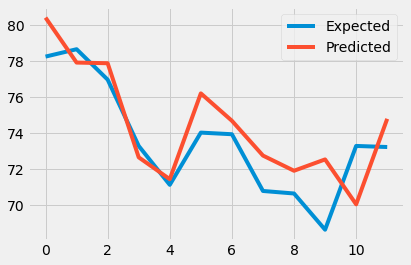

In [15]:
# load the dataset
series = read_csv('Resources/Coffee_Price_Data .csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()